##### <h1 style="color:teal; text-align:center">Recipe Review Sentiment Analysis</h1>
<h4 style="text-align:center">By Ben Rapp</h4><br>

For my Principles of Data Science final project, I conducted a __sentiment analysis__ of food reviews. Sentiment analysis is the process of using __NLP__ to determine the emotional intent behind someone's words. Online food reviews lend themselves well to sentiment analysis, since users are inherently opinionated about the recipe they cooked.  

The dataset I used provided me with both reviews and a rating (0-5), meaning I couuld approach this task as __supervised learning__ problem. In supervised learning, we are provided with both data and labels telling us what __class__ each data point falls into. In my case, I just have two classes- positive reviews and negative reviews. This is called __binary classification__. 

There are a number of algorithms that we can use for binary classification. One of the most popular algorithms is called __Logistic Regression__. This algorithm basically draws a line between two classes of data and uses a fancy function to form a probability curve out of that line. The result looks like this: 

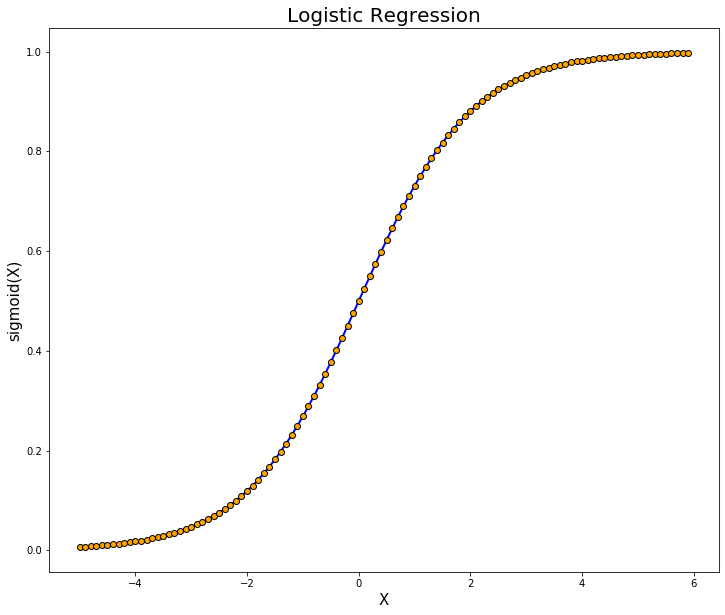

I'll come back to this later. For now, let's check out our dataset! 

In [1]:
# Imports 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import re
import nltk
import spacy 
%matplotlib inline 

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import (KNeighborsClassifier, NeighborhoodComponentsAnalysis)
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.decomposition import TruncatedSVD

In [2]:
interactions = pd.read_csv('./interactions/RAW_interactions.csv')

## EDA

The two sections that matter in this example are our __data__ (reviews) and the __labels__ (ratings). We need to take a look at both of these features in order to make some important decisions about the data.<br>

### Dataset: 
There are some useful functions in pandas that allow us to check out the dataset and get an idea of what we're working with: 

In [3]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132367 entries, 0 to 1132366
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   user_id    1132367 non-null  int64 
 1   recipe_id  1132367 non-null  int64 
 2   date       1132367 non-null  object
 3   rating     1132367 non-null  int64 
 4   review     1132198 non-null  object
dtypes: int64(3), object(2)
memory usage: 43.2+ MB


In [4]:
interactions['review'].describe()

count        1132198
unique       1125282
top       Delicious!
freq             309
Name: review, dtype: object

In [5]:
interactions['rating'].describe()

count    1.132367e+06
mean     4.411016e+00
std      1.264752e+00
min      0.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

### Ratings:

Classifying reviews as positive / negative is called __binary classification__, since there are two possible values our __labels__ can take: +1 or -1.<br> 

One issue that we have with the ratings is that they go from 0-5. So, we'll have to make a choice about the cutoff for what rating values get assigned to the label of +1 or -1.<br>

Let's inform that decision by looking at the distribution of ratings in the dataset: 

<AxesSubplot:xlabel='rating'>

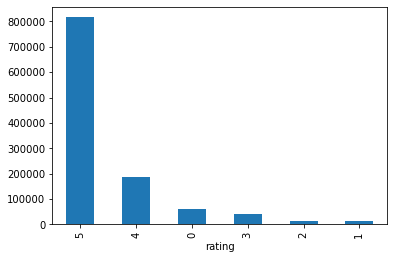

In [6]:
interactions.value_counts('rating').plot.bar(x='rating')

As you can see, there's an enormous __imbalance__ in our dataset- there are way more high ratings than low ratings!<br>

So, let't include 0-3 in the negative class (-1) and ratings of 4-5 in the positive class (+1). 

## Data Cleaning 

To clean the dataset, there are a few obvious steps we need to take:<br>
1. Drop missing reviews (doesn't make sense to fill them in this case)
2. Drop duplicate reviews
3. lowercase all reviews
4. Strip HTML other extraneous non-alphanumeric characters
5. "Tokenize" the data, which just turns each individual word into its own entry in a list. This is convenient for the word embedding models we will eventually use.

<b>Removing Stopwords</b><br>
Stopwords are a set of commonly used english words. Both of our word embedding models, TF-IDF and BoW, are based on the relative or absolute frequency of words in the "dictionary" of words from all of the reviews. Because of this, removing stopwords allows our models to learn based on words that more accurately convey affect.

<b>Brown Corpus</b><br> 
Because there are a lot of misspelled words or words that are specific to the online source that the reviews were pulled from (usernames, references to site artifacts, etc.), I decided to make my life easy by removing words that are not part of a large collection of english words. This is <b>GENERALLY NOT A GOOD PRACTICE</b>, as we can loose a lot of information from the text this way, especially with a smaller set of data. <br><br>
I made this choice for the purpose of the demo, just so that the results are a bit cleaner and easier to interpret. I strongly recommend that you do not do this- you should generally spend 80% of your time cleaning the data and 20% training and testing your models. I'm setting a bad example with this move. 

In [9]:
# Example of a "dirty" review: 
interactions['review'][12]

'made my own buttermilk w  vinegar and milk   used defrosted fresh skinless boneless chicken fillets   3 lbs   this mix is extremely flavorful and its light    i didnt do the bbq thing  but while i cooked homemade to go w  this i put the chicken in the oven to keep warm and served bbq dipping sauce   10 stars from my kids  '

In [10]:
# Dropping Missing Values 
interactions = interactions.dropna(axis=0, inplace=False)

# Dropping Duplicate Reviews 
interactions = interactions.drop_duplicates(subset=['review'])

# Lowercase, Strip HTML Characters, Tokenize, Remove Stopwords
interactions['review'] = interactions['review'].str.lower()
interactions['review'] = interactions['review'].str.replace('[^0-9A-Za-z ]', ' ', regex=True)
interactions['review'] = interactions['review'].apply(nltk.tokenize.word_tokenize)
stopwords = set(nltk.corpus.stopwords.words('english'))
interactions['review'] = interactions['review'].apply(lambda x: [word for word in x if word not in stopwords])

# Removing words that are not a part of the Brown Corpus 
# brown_words = set(nltk.corpus.brown.words())
# interactions['review'] = interactions['review'].apply(lambda x: [word for word in x if word in brown_words])
interactions['review'][12]


['made',
 'buttermilk',
 'w',
 'vinegar',
 'milk',
 'used',
 'defrosted',
 'fresh',
 'skinless',
 'boneless',
 'chicken',
 'fillets',
 '3',
 'lbs',
 'mix',
 'extremely',
 'flavorful',
 'light',
 'didnt',
 'bbq',
 'thing',
 'cooked',
 'homemade',
 'go',
 'w',
 'put',
 'chicken',
 'oven',
 'keep',
 'warm',
 'served',
 'bbq',
 'dipping',
 'sauce',
 '10',
 'stars',
 'kids']

That's better!

## Preprocessing

Now, it's time to start __preprocessing__ our data, which means we're preparing it to get run through our machine learning models. <br> 
We need to preprocess both the labels and the data.<br> 
Starting with the labels, let's convert the ratings into +1/-1 values and fix our data imbalance problem.

<AxesSubplot:xlabel='target'>

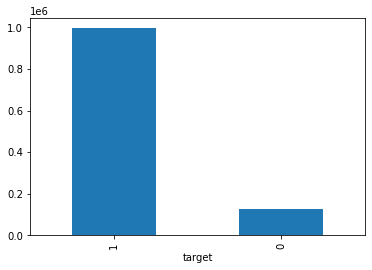

In [11]:
targets = (interactions['rating'] >= 4).astype(int)
interactions['target'] = targets
interactions.value_counts('target').plot.bar()

Because there are so many more positive examples than negative examples, our classifiers will have a hard time learning and will give us terrible accuracy scores. Also, think about the problem. In the real world, data imbalance is natural for rare events. Does it make sense that recipes are all delicious and everyone loves them? It's sometimes a dangerous assumption to make, but we will assume that the reason for this massive imbalance in our data is due to the behavior of the subset of people on Food.com. <br>

The easiest way to combat data imbalance is by __undersampling__. We will randomly sample a subset of the positive examples so that it's close to the same size as the negative examples. 

Proportion of negative to positive samples:  0.1282191879873221


<AxesSubplot:>

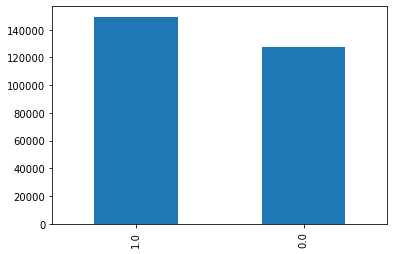

In [12]:
zeros = interactions.where(interactions["target"] == 0).dropna()
ones = interactions.where(interactions["target"] == 1).dropna()
print("Proportion of negative to positive samples: ", len(zeros)/len(ones))

sample = ones.sample(frac=0.15)
sample = pd.concat([zeros,sample])
sample['target'].value_counts().plot.bar()

In [13]:
sample = sample.reset_index().drop(['index', 'user_id', 'recipe_id', 'rating', 'date'],axis=1)
sample['review'] = sample['review'].apply(lambda x: " ".join(str(word) for word in x))

Now that our data imbalance problem is fixed, let's employ two different word-embedding models to transform our data so that it is machine-interpretable.

### Bag of Words (BoW)
The __Bag of Words__ model is a fancy name for a word count. Essentially, for each word in our dataset, the BoW model creates a vector of word counts, where each entry in the vector represents a food review. We can implement this model with the ScikitLearn CountVectorizer function.

In [14]:
# Splitting the dataset for convenience

X = sample["review"].values
y = sample["target"].values

In [15]:
# Bag of Words model using CountVectorizer()
word_count_example = CountVectorizer(stop_words="english").fit(X)

# Length of dictionary mapping words to vector indices
len(word_count_example.vocabulary_)

72005

To show you an example of what the dataset looks like, check this out: 

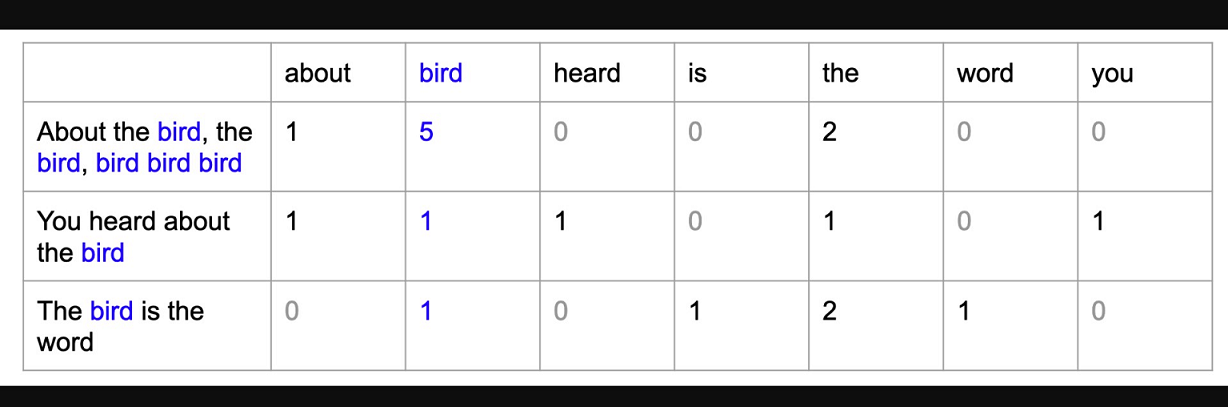

### TF-IDF + n-gram
__TF-IDF__ stands for Term Frequency - Inverse Document Frequency. It is a statistic that represents how frequently a word comes up in a given review compared to how many reviews contain that word.<br> 
It's a very common statistic in NLP, and turns out to be very powerful in determining a word's importance to a collection of documents (reviews, in our case).<br><br>
An __n-gram__ is a phrase containing n words, simply put. This is a really useful tool for handling things like negations. For example, I could say, "My food was delicious!" or "My food was not delicious!" The word "not" literally flips the sentiment of what the user was trying to say, so having an n-gram parameter in our TF-IDF word embedding makes it so that every 2-permutation of terms in the dataset are accounted for in our model training. This almost always helps our accuracy in sentiment analysis. 

In [16]:
# TF-IDF Embedding with 1- and 2-grams included. Notice how there are so many more entries in the vector, to account for all n-gram permutations.
tfidf_example = TfidfVectorizer(ngram_range=(1,2),stop_words = 'english').fit(X)
len(tfidf_example.vocabulary_)

1827356

The dataset now looks like the previous example, but with a large number of extra entries. This is due to all of the 2-grams that are formed by consecutive words in the reviews. 

## Model Training, Testing and Evaluation
Now, it's time for the fun part! <br><br>
I want to preface this section with a quick explanation of how Logistic Regression works, the classifier we'll use for this problem. 

Recall the probability curve that Logistic Regression produces after we train it.

The y-axis represents the probability that a data point belongs to the negative (0) or positive (1) class. Notably, the data points can fall somewhere __between__ 0 and 1- this is useful because it gives us a level of __confidence__ for what class a point belongs to. For example, a point with a y-value of 0.8 is a strongly positive point, but what about one that's at 0.55? It's much closer to the cutoff between classes.<br><br>

Remember how I said that Logistic Regression generates a line and crunches it into a fancy function? Well, the line that gets produced before we turn it into a probability curve depends on each of the features in the dataset. For example, in a 2d problem with two variables $x1$ and $x2$, $c = ax1 + bx2$. <br><br>

This means that we can determine the importance of each feature based on the coefficients a and b. In sentiment analysis, each feature is a word in the dataset. So, the largest coefficients correspond to the words that carry the most weight in determining how positive/negative a review is. 
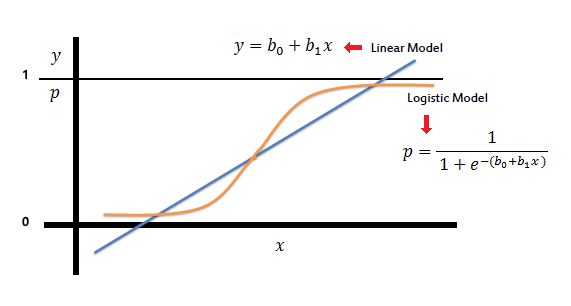

Below, I'll define a function to do the following: <br> 

1. Transform the data with either BoW or TF-IDF 

2. Split the dataset into training and test sets

3. Train our Logistic Regression model with the training set 

4. Make predictions using the test data 

5. Evaluate and report the accuracy of our predictions against the test labels 

6. Use the linearity of the weights of Logistic Regression to determine the top 10 most positively- and negatively- correlated words. 

7. Plot an ROC (Reciever Operating Characteristic) curve to evaluate the area underneath it (AUC). 

In [27]:
def fit_reviews(X, y, transform, model, display, roc):

    X_trans = transform.fit_transform(X)
    Xtr, Xte, ytr, yte = train_test_split(X_trans, y, test_size=0.1, random_state=42)
    classifier = model.fit(Xtr, ytr)
    acc = classifier.score(Xte, yte)
    predictions = classifier.predict(Xte)
#     precision = precision_score(y, predictions)
#     recall = recall_score(y, predictions)
#     f1 = recall_score(y, predictions)
    print("Accuracy: ", acc)
#     print("Precision: ", precision)
#     print("Recall: ", recall)
#     print("F1-Score: ", f1)
    
#     conf_matrix = confusion_matrix(y, predictions)
#     print("Confusion Matrix: ", conf_matrix)
    
    
    
    
    # Find out about the words that the model was messing around with 
    if(display == 1):
        w = transform.get_feature_names()
        coefficients = classifier.coef_.tolist()[0]
        word_weights = pd.DataFrame({'Word' : w, 'Coefficient' : coefficients})
        word_weights = word_weights.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
        print('')
        print('10 most positive words:')
        print(word_weights.head(10))
        print('')
        print('10 most negative words:')        
        print(word_weights.tail(10))
    
    # Display ROC curve to evaluate model
    if(roc==1):
        plot_roc_curve(model, Xte, yte)
        plt.show()
    
    return acc


C:\Users\Benra\anaconda3\lib\site-packages\sklearn\dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


Accuracy:  0.5053519299383717


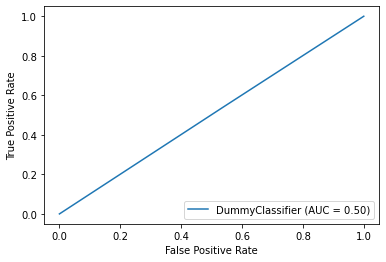

0.5053519299383717

In [28]:
# Baseline results using dummy classifier with raw TFIDF

dummy = DummyClassifier()
tf = TfidfVectorizer()
fit_reviews(X, y, tf, dummy, 0, 1)

In [35]:
# 1) Logistic Regression: 

lr_result_array = []

# (a) Baseline using dummy classifier 
lr_result_array.append(("Baseline",fit_reviews(X, y, CountVectorizer(stop_words="english"), DummyClassifier(), 0, 0)))
lr_result_array

# Define our three different word embeddings 
c = CountVectorizer(stop_words = "english")
tfidf_raw = TfidfVectorizer()
tfidf_2 = TfidfVectorizer(ngram_range=(1,2),stop_words = 'english')

Accuracy:  0.50124337766245


C:\Users\Benra\anaconda3\lib\site-packages\sklearn\dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


In [36]:
# (b) LR / Count Vectorizer 

lr_result_array.append(("LR/CountVec, C=" + str(0.25),fit_reviews(X, y, c, 
        LogisticRegression(penalty='l2', C = 0.25, max_iter=500, solver="saga"), 1, 0)))

Accuracy:  0.7760839009622662

10 most positive words:
             Word  Coefficient
15217        tour     1.369057
15333  travellers     1.095417
11954  refreshing     1.095233
8314       kitten     1.006037
5595    exquisite     0.973191
13376     sipping     0.956502
5446    excellent     0.934940
7718   incredible     0.904960
4347     devoured     0.901697
10094      orders     0.878933

10 most negative words:
                Word  Coefficient
7358           hopes    -1.386701
7375        horrible    -1.405127
1713           bland    -1.433245
10016           okay    -1.450401
1161          assign    -1.504210
14773      tasteless    -1.670192
8367          lacked    -1.686784
13734          sorry    -1.764928
16548          worst    -1.911909
4482   disappointing    -1.964152


In [37]:
# (c) LR / Raw TFIDF

lr_result_array.append(("LR/Raw TFIDF, C=" + str(0.25),fit_reviews(X, y, tfidf_raw, 
    LogisticRegression(penalty='l2', C = 0.25, max_iter=500, solver="saga"), 1, 0)))

Accuracy:  0.7831477276822719

10 most positive words:
            Word  Coefficient
15068     thanks     5.955619
6865       great     4.153606
16676  wonderful     3.893863
10689    perfect     3.623078
4183   delicious     3.401054
16034       used     3.390441
14843        tag     3.365094
8897       loved     3.353822
5286     enjoyed     3.329074
5500   excellent     3.248088

10 most negative words:
                Word  Coefficient
2399            care    -2.869206
16726          worst    -2.925045
8446          lacked    -3.047523
11845         rating    -3.066430
15832  unfortunately    -3.070731
11841           rate    -3.411434
4520    disappointed    -3.680378
10123           okay    -4.814360
1743           bland    -5.696971
13870          sorry    -6.905825


In [38]:
# (d) LR / TFIDF + 2-grams

lr_result_array.append(("LR/TFIDF+2gram, C=" + str(0.25),fit_reviews(X, y, tfidf_2, 
    LogisticRegression(penalty='l2', C = 0.25, max_iter=500, solver="saga"), 1, 0)))



Accuracy:  0.7850578440912531

10 most positive words:
              Word  Coefficient
1100353     thanks    10.864660
1221265  wonderful     6.469139
627559       loved     6.279796
469995       great     6.276171
1172542       used     6.150385
773589     perfect     6.072093
282352   delicious     5.738863
359073   excellent     5.081374
349165     enjoyed     5.058241
1076915        tag     5.055541

10 most negative words:
                Word  Coefficient
849005        rating    -4.050790
325186           dry    -4.083098
158234          care    -4.114916
848062          rate    -4.203556
66673            bad    -4.207402
304471  disappointed    -4.824791
653045         maybe    -5.168665
727613          okay    -6.647425
107224         bland    -8.549924
998866         sorry    -9.658669


### Results: 

In [34]:
lr_result_array

[('Baseline', 0.5018200165783688),
 ('LR/CountVec, C=0.25', 0.776192020759001),
 ('LR/TFIDF+2gram, C=0.25', 0.7850578440912531),
 ('LR/Raw TFIDF, C=0.25', 0.7831477276822719)]